<a href="https://colab.research.google.com/github/francis-jeon/Repository_francis/blob/main/anomaly_detection_minjong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset download via Kaggle API

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download podsyp/find-a-defect-in-the-production-extrusion-line

find-a-defect-in-the-production-extrusion-line.zip: Skipping, found more recently modified local copy (use --force to force download)


#<strong> Machine Learning approach: LGBM </strong>

##Import neccesary libraries / dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import os
import sys
import warnings
import seaborn as sns

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import zipfile 
dataset_path = "/content/find-a-defect-in-the-production-extrusion-line.zip"
zfile = zipfile.ZipFile(dataset_path)
zfile.extractall()

In [7]:
data = pd.read_csv('/content/extrusion.csv')

data.head()

,Datum,ST0_VARActAuftrag,ST110_VARExtr_0_HeizungZone_3_Regler_Y,ST110_VARExtr_0_HeizungZone_3_SollTemp,ST110_VARExtr_0_HeizungZone_4_Konfig,ST110_VARExtr_0_HeizungZone_4_Regler_X,ST110_VARExtr_0_HeizungZone_4_Regler_Y,ST110_VARExtr_0_HeizungZone_4_SollTemp,ST110_VARExtr_0_HeizungZone_5_Konfig,ST110_VARExtr_0_HeizungZone_5_Regler_X,...,ST114_VARTensPlusSp,ST114_VARTotalLen,ST114_VARTotalRolls,ST114_VARWdCloseCmd,ST114_VARWdSpeedHMI,ST114_VARWdSpSpeed,ST114_VARWdSpTens,ST114_VARWdTapeNum,ST114_VARWdTapeReductVal,ST114_VARWdTensVis
0,25.06.2018 4:40,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,21.0,3544103.0,2174.0,1.0,78.0,0.0,50.0,5.0,15.0,53.0
1,25.06.2018 4:42,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,21.0,3544103.0,2174.0,1.0,81.0,0.0,50.0,5.0,15.0,49.0
2,25.06.2018 4:45,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,21.0,3544103.0,2174.0,1.0,81.0,0.0,50.0,5.0,15.0,48.0
3,25.06.2018 4:47,0.0,10.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,21.0,3544103.0,2174.0,1.0,81.0,0.0,50.0,5.0,15.0,50.0
4,25.06.2018 4:49,0.0,11.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,21.0,3544103.0,2174.0,1.0,81.0,0.0,50.0,5.0,15.0,51.0


##Preprocessing Steps 1: Checking Null Values

In [8]:
Sum = data.isnull().sum().sort_values(ascending=False)
percent = ((data.isnull().sum()/data.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([Sum, percent], axis=1, keys=['Sum', 'Percent'])
missing_data

,Sum,Percent
ST114_VARWdTensVis,1101,0.486015
ST114_VARLmpRun,1101,0.486015
ST114_VARGesamtZeit,1101,0.486015
ST114_VARGapMin,1101,0.486015
ST114_VARGapMax,1101,0.486015
...,...,...
ST110_VARExtr_3_HeizungZone_8_Regler_Y,62,0.027369
ST110_VARExtr_3_HeizungZone_8_Regler_X,62,0.027369
ST110_VARExtr_0_HeizungZone_3_SollTemp,62,0.027369
ST0_VARActAuftrag,0,0.000000


In [9]:
from datetime import datetime
data['year'] = pd.to_datetime(data['Datum']).dt.strftime('%Y')
data['month'] = pd.to_datetime(data['Datum']).dt.strftime('%M')
data['date'] = pd.to_datetime(data['Datum']).dt.strftime('%d')

In [10]:
data.head()

,Datum,ST0_VARActAuftrag,ST110_VARExtr_0_HeizungZone_3_Regler_Y,ST110_VARExtr_0_HeizungZone_3_SollTemp,ST110_VARExtr_0_HeizungZone_4_Konfig,ST110_VARExtr_0_HeizungZone_4_Regler_X,ST110_VARExtr_0_HeizungZone_4_Regler_Y,ST110_VARExtr_0_HeizungZone_4_SollTemp,ST110_VARExtr_0_HeizungZone_5_Konfig,ST110_VARExtr_0_HeizungZone_5_Regler_X,...,ST114_VARWdCloseCmd,ST114_VARWdSpeedHMI,ST114_VARWdSpSpeed,ST114_VARWdSpTens,ST114_VARWdTapeNum,ST114_VARWdTapeReductVal,ST114_VARWdTensVis,year,month,date
0,25.06.2018 4:40,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,1.0,78.0,0.0,50.0,5.0,15.0,53.0,2018,40,25
1,25.06.2018 4:42,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,1.0,81.0,0.0,50.0,5.0,15.0,49.0,2018,42,25
2,25.06.2018 4:45,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,1.0,81.0,0.0,50.0,5.0,15.0,48.0,2018,45,25
3,25.06.2018 4:47,0.0,10.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,1.0,81.0,0.0,50.0,5.0,15.0,50.0,2018,47,25
4,25.06.2018 4:49,0.0,11.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,...,1.0,81.0,0.0,50.0,5.0,15.0,51.0,2018,49,25


##Preprocessing Steps 2: Determining target variable

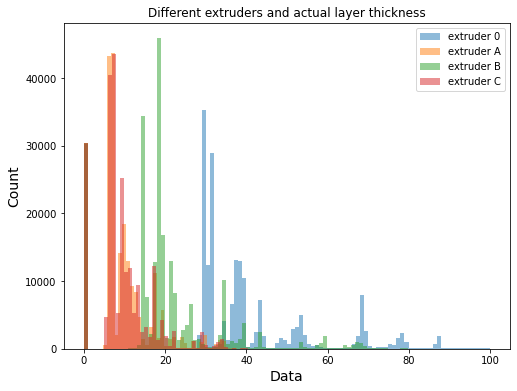

In [11]:
plt.figure(figsize=(8,6))
plt.hist(data[data['ST110_VAREx_0_SDickeIst'] < 100]['ST110_VAREx_0_SDickeIst'], bins=100, alpha=0.5, label="extruder 0")
plt.hist(data[data['ST110_VAREx_1_SDickeIst'] < 100]['ST110_VAREx_1_SDickeIst'], bins=100, alpha=0.5, label="extruder A")
plt.hist(data[data['ST110_VAREx_2_SDickeIst'] < 100]['ST110_VAREx_2_SDickeIst'], bins=100, alpha=0.5, label="extruder B")
plt.hist(data[data['ST110_VAREx_3_SDickeIst'] < 100]['ST110_VAREx_3_SDickeIst'], bins=100, alpha=0.5, label="extruder C")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Different extruders and actual layer thickness")
plt.legend(loc='upper right')

In [12]:
data['EXT0'] = data['ST110_VAREx_0_SDickeIst'].apply(lambda x: 1 if x == 0 else 0)
data['EXTA'] = data['ST110_VAREx_1_SDickeIst'].apply(lambda x: 1 if x == 0 else 0)
data['EXTB'] = data['ST110_VAREx_2_SDickeIst'].apply(lambda x: 1 if x == 0 else 0)
data['EXTC'] = data['ST110_VAREx_3_SDickeIst'].apply(lambda x: 1 if x == 0 else 0)
data['EXTsum'] = data['EXTC']+data['EXTA']+data['EXTB']+data['EXT0']
data['EXTtotal'] = data['EXTsum'].apply(lambda x: 0 if x == 0 else 1)

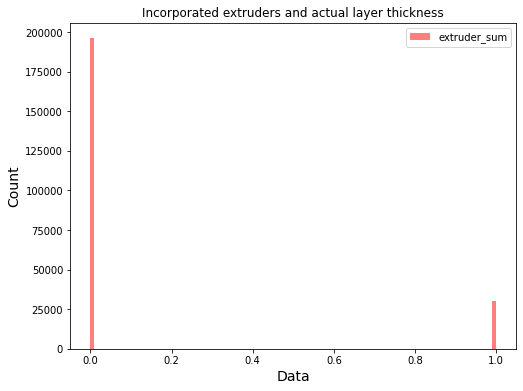

In [13]:
plt.figure(figsize=(8,6))
plt.hist(data[data['EXTtotal'] < 100]['EXTtotal'], bins=100, alpha=0.5, label="extruder_sum", color='r')
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Incorporated extruders and actual layer thickness")
plt.legend(loc='upper right')

##Preprocessing Steps 3: 

* Since the dataset is time series one, the colum 'Dataum' is utilized as index

* Delete unneccessary columns and fill N/A

* Find categoricla columns -> if exist, should be converted via One-Hot encoding or Label encoding






---



In [14]:
data['Datum'] = pd.to_datetime(data['Datum'])
data = data.set_index('Datum')
data.head()

,ST0_VARActAuftrag,ST110_VARExtr_0_HeizungZone_3_Regler_Y,ST110_VARExtr_0_HeizungZone_3_SollTemp,ST110_VARExtr_0_HeizungZone_4_Konfig,ST110_VARExtr_0_HeizungZone_4_Regler_X,ST110_VARExtr_0_HeizungZone_4_Regler_Y,ST110_VARExtr_0_HeizungZone_4_SollTemp,ST110_VARExtr_0_HeizungZone_5_Konfig,ST110_VARExtr_0_HeizungZone_5_Regler_X,ST110_VARExtr_0_HeizungZone_5_Regler_Y,...,ST114_VARWdTensVis,year,month,date,EXT0,EXTA,EXTB,EXTC,EXTsum,EXTtotal
Datum,,,,,,,,,,,,,,,,,,,,,
2018-06-25 04:40:00,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,22.0,...,53.0,2018,40,25,0,0,0,0,0,0
2018-06-25 04:42:00,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,23.0,...,49.0,2018,42,25,0,0,0,0,0,0
2018-06-25 04:45:00,0.0,9.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,22.0,...,48.0,2018,45,25,0,0,0,0,0,0
2018-06-25 04:47:00,0.0,10.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,23.0,...,50.0,2018,47,25,0,0,0,0,0,0
2018-06-25 04:49:00,0.0,11.0,190.0,1.0,193.0,0.0,190.0,1.0,190.0,23.0,...,51.0,2018,49,25,0,0,0,0,0,0


In [15]:
data = data.drop(['EXT0', 'EXTA', 'EXTB', 'EXTC', 'EXTsum'], axis = 1)
data = data.fillna(data.interpolate())
data.isnull().sum().sum()

0

In [16]:
objList = data.select_dtypes(include = "object").columns
print(objList)

Index(['year', 'month', 'date'], dtype='object')


##Preprocessing Steps 4: Simple EDA on target variable

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


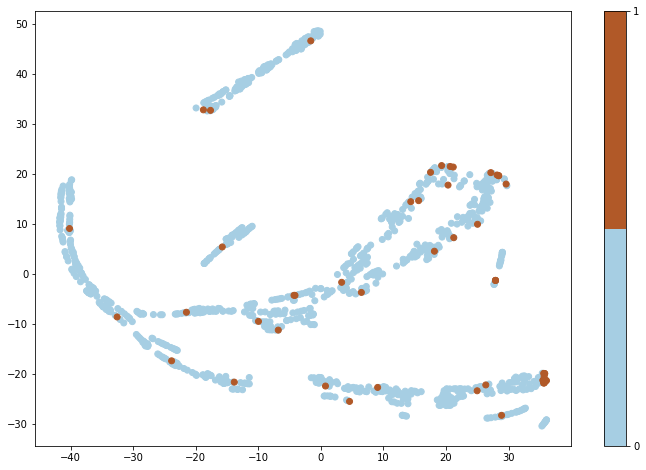

In [40]:
from sklearn.manifold import TSNE

data_tsne=data[data['EXTtotal']==0].sample(1000)
data_tsne_abnormal=data[data['EXTtotal']==1].sample(50)
data_tsne=pd.concat([data_tsne,data_tsne_abnormal])
y_plt=data_tsne['EXTtotal']
X_plt=data_tsne.drop('EXTtotal',1)

X_embedded = TSNE(n_components=2).fit_transform(X_plt)

plt.figure(figsize=(12,8))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_plt, cmap=plt.cm.get_cmap("Paired", 2))
plt.colorbar(ticks=range(2))

In [41]:
pred = data.drop(['EXTtotal'], axis=1)
target = data['EXTtotal']

##Preprocessing Steps 5: PCA since more than 400 columns exist

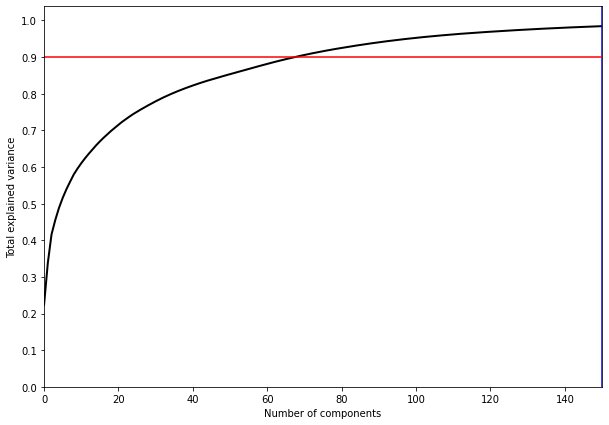

In [42]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler().fit(pred)
pred=scaler.transform(pred)

pca = decomposition.PCA().fit(pred)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 150)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(150, c='b')
plt.axhline(0.9, c='r')
plt.show();

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=70)
pca_result = pca.fit_transform(pred)
pca_result = pd.DataFrame(pca_result)
pca_result.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,-5.072246,7.357941,4.183902,-2.526993,-3.521885,4.260270,-0.938188,-1.437169,1.654942,1.654406,...,-1.128270,0.424442,0.729024,0.282196,0.356701,0.426859,0.066971,0.840065,0.317818,-0.682380
1,-5.064349,7.229688,3.873653,-2.672058,-3.606416,3.967448,-0.973017,-1.478281,1.582857,1.608470,...,-1.101358,0.545101,0.757268,0.057585,0.259156,0.336829,0.020518,0.905177,0.422143,-0.753020
2,-5.058324,7.356764,4.073729,-2.593525,-3.532983,4.025118,-1.035675,-1.541641,1.697382,1.665954,...,-1.142420,0.518255,0.712835,0.329614,0.232590,0.356160,-0.032227,0.831220,0.339459,-0.641039
3,-5.147337,7.346690,3.846870,-2.590595,-3.513573,4.022755,-1.022722,-1.576625,1.612561,1.672074,...,-1.138614,0.558855,0.732960,0.144645,0.120944,0.347157,-0.109489,0.907756,0.362273,-0.659437
4,-5.168501,7.348891,3.870708,-2.587257,-3.502351,3.956036,-1.073956,-1.633734,1.620984,1.702258,...,-1.053120,0.473688,0.745958,0.224778,0.069755,0.300355,-0.288132,0.897269,0.469129,-0.634236


##Preprocessing Steps 6: Train test split for suprervised learning approach: LGBM

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(pca_result, target, test_size=0.2, random_state=77, stratify=target)

In [52]:
#lgbm

import lightgbm  as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

lgb = LGBMClassifier(random_state=12)

lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_test)

acc_lgb = round(accuracy_score(y_pred_lgb, y_test)*100, 2)

print(acc_lgb)

99.92


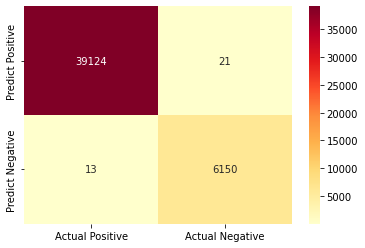

In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_lgb)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'], 
                                 index=['Predict Positive', 'Predict Negative'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlOrRd')

Text(0.5, 0, 'False Positive Rate')

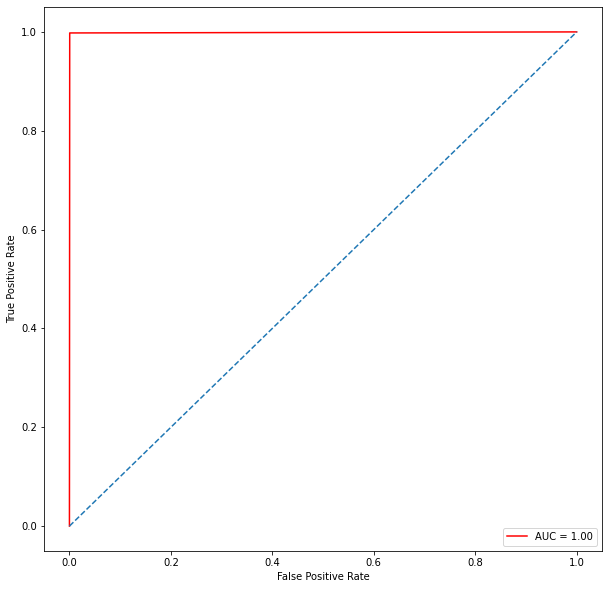

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import classification_report, accuracy_score

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_lgb)
roc_auc = auc(false_positive_rate, true_positive_rate)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [55]:
n_errors = (y_pred_lgb != y_test).sum()
n_errors

34

In [56]:
print(classification_report(y_test,y_pred_lgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39145
           1       1.00      1.00      1.00      6163

    accuracy                           1.00     45308
   macro avg       1.00      1.00      1.00     45308
weighted avg       1.00      1.00      1.00     45308



# Anomaly detection algorithms: Isolation Forest, Local Outlier, One Class SVM: 

##For these algorithms, "pca_result", and "target" will be utilized instead of "X_train" or "y_train"

In [52]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


abnormal = target[target == 1]
normal = target[target == 0]

abnormal_proportion = len(abnormal) / float(len(normal))

abnormal_proportion

0.15539506701756534

##Define three classifiers 

In [56]:
classifiers = {
    "Isolation Forest":IsolationForest(max_samples=len(pred), contamination=abnormal_proportion,random_state=77, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(contamination=abnormal_proportion),
    "Support Vector Machine":OneClassSVM(kernel='rbf', gamma=0.1)
}

In [ ]:
n_outliers = len(abnormal)

for i, (clf_name,clf) in enumerate(classifiers.items()):
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(pca_result)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(pca_result)
        y_pred = clf.predict(pca_result)
    else:    
        clf.fit(pca_result)
        scores_prediction = clf.decision_function(pca_result)
        y_pred = clf.predict(pca_result)
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != target).sum()

    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(target,y_pred))
    print("Classification Report :")
    print(classification_report(target,y_pred))
    print("Confusion Matrix :")
    print(confusion_matrix(target, y_pred))

Isolation Forest: 39051
Accuracy Score :
0.827616802627397
Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.89      0.90    196068
           1       0.38      0.44      0.41     30468

    accuracy                           0.83    226536
   macro avg       0.64      0.66      0.65    226536
weighted avg       0.84      0.83      0.83    226536

Confusion Matrix :
[[174175  21893]
 [ 17158  13310]]
Local Outlier Factor: 51971
Accuracy Score :
0.7705839248507963
Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.86      0.87    196068
           1       0.19      0.22      0.21     30468

    accuracy                           0.77    226536
   macro avg       0.54      0.54      0.54    226536
weighted avg       0.78      0.77      0.78    226536

Confusion Matrix :
[[167715  28353]
 [ 23618   6850]]
